# Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [24]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

ImportError: cannot import name 'load_data' from 'common' (/Users/timovijn/opt/miniconda3/envs/timo/lib/python3.8/site-packages/common/__init__.py)

In [2]:
import pandas as pd
import numpy as np

hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates

import matplotlib.font_manager as font_manager
mpl.font_manager._rebuild()

mpl.rcParams['font.family'] = 'SF Mono'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])
mpl.rcParams["figure.titlesize"] = 'large'
mpl.rcParams["figure.titleweight"] = 'semibold'

from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score

import tensorflow as tf

from entsoe import EntsoePandasClient

Load data into Pandas dataframe

In [3]:
features = pd.read_pickle(f"./features.pkl")

In [4]:
features = features[['ID3', 'LOAD']]

In [5]:
features.head(5)

,ID3,LOAD
2015-01-08 01:00:00+00:00,22.953776,9008.00
2015-01-08 02:00:00+00:00,23.168355,8889.25
2015-01-08 03:00:00+00:00,21.000000,8929.25
2015-01-08 04:00:00+00:00,30.000000,9423.75
2015-01-08 05:00:00+00:00,30.000000,10884.50


In [6]:
features.tail(5)

,ID3,LOAD
2018-12-30 14:00:00+00:00,53.790740,13842.50
2018-12-30 15:00:00+00:00,59.477646,14319.25
2018-12-30 16:00:00+00:00,59.883829,15120.75
2018-12-30 17:00:00+00:00,59.471501,14728.75
2018-12-30 18:00:00+00:00,58.448950,14296.50


In [7]:
# energy = load_data('data/')
# energy.head()

In [11]:
valid_start_dt = '2017-01-01 00:00:00'
test_start_dt = '2018-01-01 00:00:00'

T = 6
HORIZON = 3

Create training set containing only the model features

In [12]:
train = features.copy()[features.index < valid_start_dt][['ID3', 'LOAD']]

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [13]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['ID3']])

X_scaler = MinMaxScaler()
train[['ID3', 'LOAD']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [29]:
class TimeSeriesTensor(UserDict):
    """A dictionary of tensors for input into the RNN model.
    
    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape 
         (samples, time steps, features) for input into Keras
    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """
    
    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())
        
        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)
    
    def _shift_data(self, H, freq, drop_incomplete):
        
        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()
        
        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]
            
            for col in dataset_cols:
            
            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))
                
        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df

    def _df2tensors(self, dataframe):
        
        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']
    
        inputs = {}
        y = dataframe['target']
        y = y.to_numpy()
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].to_numpy()
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs
       
    def subset_data(self, new_dataframe):
        
        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.
        
        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [110]:
# tensor_structure = {'X':(range(-T+1, 1), ['ID3', 'LOAD'])}
# train_inputs = TimeSeriesTensor(train, 'ID3', HORIZON, {'X':(range(-T+1, 1), ['ID3', 'LOAD'])})

tensor_structure = {'X':(range(-T-3, -3), ['ID3', 'LOAD'])}
train_inputs = TimeSeriesTensor(train, 'ID3', HORIZON, {'X':(range(-T-3, -3), ['ID3', 'LOAD'])})

In [111]:
train_inputs.dataframe.head()

tensor                       target                             X            \
feature                           y                           ID3             
time step                       t+1       t+2       t+3       t-9       t-8   
2015-01-08 10:00:00+00:00  0.152356  0.134527  0.148012  0.088625  0.089203   
2015-01-08 11:00:00+00:00  0.134527  0.148012  0.161681  0.089203  0.083354   
2015-01-08 12:00:00+00:00  0.148012  0.161681  0.161232  0.083354  0.107631   
2015-01-08 13:00:00+00:00  0.161681  0.161232  0.175495  0.107631  0.107631   
2015-01-08 14:00:00+00:00  0.161232  0.175495  0.182699  0.107631  0.143112   

tensor                                                                       \
feature                                                                LOAD   
time step                       t-7       t-6       t-5       t-4       t-9   
2015-01-08 10:00:00+00:00  0.083354  0.107631  0.107631  0.143112  0.207389   
2015-01-08 11:00:00+00:00  0.107631  0.107631  0.143112  0.144285  0.197569   
2015-01-08 12:00:00+00:00  0.107631  0.143112  0.144285  0.144148  0.200877   
2015-01-08 13:00:00+00:00  0.143112  0.144285  0.144148  0.156864  0.241771   
2015-01-08 14:00:00+00:00  0.144285  0.144148  0.156864  0.158028  0.362574   

tensor                                                                       
feature                                                                      
time step                       t-8       t-7       t-6       t-5       t-4  
2015-01-08 10:00:00+00:00  0.197569  0.200877  0.241771  0.362574  0.567669  
2015-01-08 11:00:00+00:00  0.200877  0.241771  0.362574  0.567669  0.707327  
2015-01-08 12:00:00+00:00  0.241771  0.362574  0.567669  0.707327  0.747602  
2015-01-08 13:00:00+00:00  0.362574  0.567669  0.707327  0.747602  0.757526  
2015-01-08 14:00:00+00:00  0.567669  0.707327  0.747602  0.757526  0.776857

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [112]:
from datetime import timezone

# dt.replace(tzinfo=timezone.utc)

look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)

look_back_dt = look_back_dt.replace(tzinfo=timezone.utc)

valid = features.copy()[(features.index >= look_back_dt) & (features.index < test_start_dt)][['ID3', 'LOAD']]
valid[['ID3', 'LOAD']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'ID3', HORIZON, tensor_structure)

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [113]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

In [114]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10

In [115]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(RepeatVector(HORIZON))
model.add(GRU(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [116]:
model.compile(optimizer='RMSprop', loss='mse')

In [117]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 5)                 135       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 5)              0         
_________________________________________________________________
gru_5 (GRU)                  (None, 3, 5)              180       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 1)              6         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3)                 0         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [118]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [119]:
model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

Epoch 1/10
424/424 [==============================] - 8s 8ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 2/10
424/424 [==============================] - 3s 7ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/10
424/424 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/10
424/424 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/10
424/424 [==============================] - 3s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/10
424/424 [==============================] - 4s 9ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/10
424/424 [==============================] - 3s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/10
424/424 [==============================] - 3s 8ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/10
424/424 [==============================] - 3s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/10
424/424 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0013

## Evaluate the model

In [120]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = features.copy()[test_start_dt:][['ID3', 'LOAD']]
test[['ID3', 'LOAD']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'ID3', HORIZON, tensor_structure)

In [121]:
predictions = model.predict(test_inputs['X'])

In [122]:
predictions

array([[0.10584097, 0.10932568, 0.11149807],
       [0.10784367, 0.11078738, 0.11258648],
       [0.10912863, 0.11163852, 0.11316316],
       ...,
       [0.18623433, 0.18030757, 0.17626901],
       [0.18484077, 0.1779761 , 0.17357762],
       [0.17541267, 0.1687041 , 0.16449635]], dtype=float32)

In [123]:
def create_evaluation_df(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, H+1)])
    eval_df['timestamp'] = test_inputs.dataframe.index
    eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
    eval_df['actual'] = np.transpose(test_inputs['target']).ravel()
    eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
    return eval_df

In [124]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2018-01-01 09:00:00+00:00,t+1,29.336396,24.868167
1,2018-01-01 10:00:00+00:00,t+1,30.078856,25.978476
2,2018-01-01 11:00:00+00:00,t+1,30.555230,26.555409
3,2018-01-01 12:00:00+00:00,t+1,30.807746,28.621735
4,2018-01-01 13:00:00+00:00,t+1,30.940889,29.089427


In [125]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.225629
t+2    0.236496
t+3    0.245064
Name: APE, dtype: float64

In [126]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [127]:
mape(eval_df['prediction'], eval_df['actual'])

0.2357296388011999

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

In [128]:
plot_df = eval_df[(eval_df.timestamp<'2018-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2018-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

No handles with labels found to put in legend.


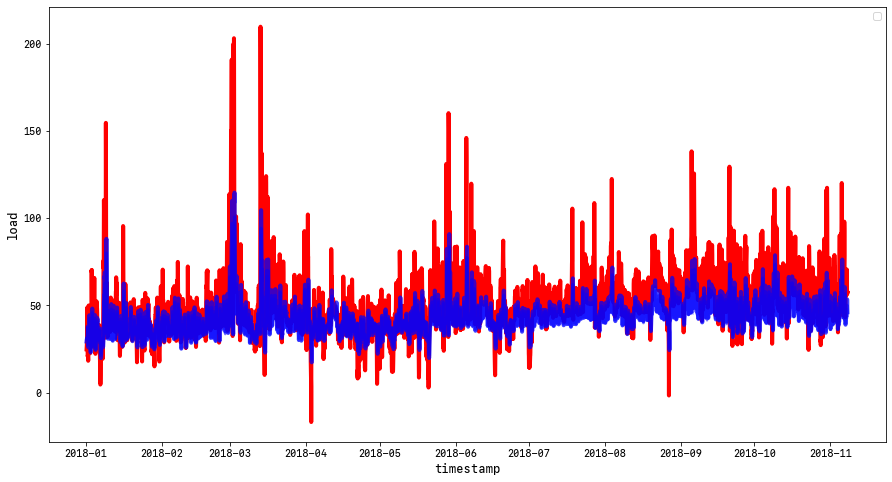

In [129]:
fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

In [131]:
import plotly.express as px
import plotly.graph_objects as go

fig1 = go.Scatter(      x = plot_df['timestamp'],
                        y = plot_df['actual'],
                        name = 'actual'
                        # color = evaluation['Type'],
                        # title = "Log of Appliance Energy Consumption in Wh vs Time"
                    )

fig2 = go.Scatter(      x = plot_df['timestamp'],
                        y = plot_df['t+1'],
                        name = 't+1'
                        # color = evaluation['Type'],
                        # title = "Log of Appliance Energy Consumption in Wh vs Time"
                    )

fig3 = go.Scatter(      x = plot_df['timestamp'],
                        y = plot_df['t+2'],
                        name = 't+2'
                        # color = evaluation['Type'],
                        # title = "Log of Appliance Energy Consumption in Wh vs Time"
                    )

fig4 = go.Scatter(      x = plot_df['timestamp'],
                        y = plot_df['t+3'],
                        name = 't+3'
                        # color = evaluation['Type'],
                        # title = "Log of Appliance Energy Consumption in Wh vs Time"
                    )

data = [fig1, fig2, fig3, fig4]

fig = go.Figure(data=data)

fig.update_layout(  height = 500,
                    width = 1250,
                    title='',
                    xaxis_title='Timestamp',
                    yaxis_title='ID3 (€)')

fig.show()